## Load The Dataset

In [1]:
!pip install tensorflow

In [2]:
# ============================================
# Load the dataset
# ============================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Make sure we see progress
print("TensorFlow version:", tf.__version__)

# Load MNIST
(x_train, y_train), (_, _) = keras.datasets.mnist.load_data()

# Scale images to [-1, 1] for tanh generator output
x_train = x_train.astype("float32")
x_train = (x_train / 127.5) - 1.0
x_train = np.expand_dims(x_train, axis=-1)  # (N, 28, 28, 1)

num_classes = 10
latent_dim = 100
batch_size = 512

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=60000).batch(batch_size, drop_remainder=True)

print("Training samples:", x_train.shape[0])


TensorFlow version: 2.19.0
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training samples: 60000


## Generator and Discriminator


In [3]:
# ============================================
# Generator and discriminator
# ============================================

def build_generator(latent_dim: int, num_classes: int):
    # Inputs
    noise_input = layers.Input(shape=(latent_dim,), name="noise_input")
    label_input = layers.Input(shape=(1,), dtype="int32", name="label_input")

    # Embed label and combine with noise
    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    x = layers.Concatenate()([noise_input, label_embedding])

    # Project and reshape
    x = layers.Dense(7 * 7 * 256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)

    # Upsampling blocks
    x = layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Output: 28x28x1, tanh to match [-1, 1]
    out = layers.Conv2DTranspose(
        1, kernel_size=5, strides=2, padding="same", activation="tanh", name="generated_image"
    )(x)

    model = keras.Model([noise_input, label_input], out, name="generator")
    return model


def build_discriminator(num_classes: int):
    image_input = layers.Input(shape=(28, 28, 1), name="image_input")
    label_input = layers.Input(shape=(1,), dtype="int32", name="label_input")

    # Embed label to image size and concatenate as extra channel
    label_embedding = layers.Embedding(num_classes, 28 * 28)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

    x = layers.Concatenate(axis=-1)([image_input, label_embedding])

    x = layers.Conv2D(64, kernel_size=5, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, kernel_size=5, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    out = layers.Dense(1, name="real_or_fake_logit")(x)  # logits: real=1, fake=0

    model = keras.Model([image_input, label_input], out, name="discriminator")
    return model


generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(num_classes)

generator.summary()
discriminator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │      1,000 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200)       │          0 │ noise_input[0][0… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12544)     │  2,508,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 12544)     │     50,176 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 12544)     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 256) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 7, 7, 128) │    819,200 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 14, 14,    │    204,800 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generated_image     │ (None, 28, 28, 1) │      1,601 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,586,345 (13.68 MB)

 Trainable params: 3,560,873 (13.58 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 784)    │      7,840 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 784)       │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 28, 28, 1) │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28, 2) │          0 │ image_input[0][0… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │      3,264 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ leaky_re_lu_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 128) │    204,928 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 7, 7, 128) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 7, 128) │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 6272)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ real_or_fake_logit  │ (None, 1)         │      6,273 │ flatten_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 222,305 (868.38 KB)

 Trainable params: 222,305 (868.38 KB)

 Non-trainable params: 0 (0.00 B)

## cGan Model

In [4]:
# ============================================
# cGAN model
# ============================================

class CGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim, num_classes):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Fixed seed for consistent image snapshots
        self.fixed_noise = tf.random.normal(shape=(num_classes * 10, latent_dim))
        self.fixed_labels = tf.repeat(tf.range(num_classes), repeats=10)[:, tf.newaxis]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.d_acc_metric = keras.metrics.BinaryAccuracy(name="d_accuracy")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric, self.d_acc_metric]

    def train_step(self, data):
        real_images, real_labels = data
        batch_size = tf.shape(real_images)[0]

        # ========================================
        # Train discriminator
        # ========================================
        # Sample noise and labels for fake images
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_labels = tf.random.uniform(
            shape=(batch_size, 1), minval=0, maxval=self.num_classes, dtype=tf.int32
        )

        fake_images = self.generator([random_noise, random_labels], training=True)

        # Real targets = 1, fake targets = 0
        real_targets = tf.ones((batch_size, 1))
        fake_targets = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            # Discriminator predictions
            real_logits = self.discriminator(
                [real_images, tf.cast(real_labels[:, tf.newaxis], tf.int32)], training=True
            )
            fake_logits = self.discriminator([fake_images, random_labels], training=True)

            # Loss for real and fake
            d_real_loss = self.loss_fn(real_targets, real_logits)
            d_fake_loss = self.loss_fn(fake_targets, fake_logits)
            d_loss = d_real_loss + d_fake_loss

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # Discriminator accuracy (after update)
        all_targets = tf.concat([real_targets, fake_targets], axis=0)
        all_preds = tf.concat([tf.math.sigmoid(real_logits), tf.math.sigmoid(fake_logits)], axis=0)
        self.d_acc_metric.update_state(all_targets, all_preds)

        # ========================================
        # Train generator
        # ========================================
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        sampled_labels = tf.random.uniform(
            shape=(batch_size, 1), minval=0, maxval=self.num_classes, dtype=tf.int32
        )

        trick_targets = tf.ones((batch_size, 1))  # generator wants D to output "real"

        with tf.GradientTape() as tape:
            generated_images = self.generator([random_noise, sampled_labels], training=True)
            gen_logits = self.discriminator([generated_images, sampled_labels], training=True)
            g_loss = self.loss_fn(trick_targets, gen_logits)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        # Update loss metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "d_accuracy": self.d_acc_metric.result(),
        }

    def generate_labeled_images(self, num_per_class=10):
        """Generate images for digits 0-9 with labels for visualization."""
        labels = tf.repeat(tf.range(self.num_classes), repeats=num_per_class)[:, tf.newaxis]
        noise = tf.random.normal(shape=(self.num_classes * num_per_class, self.latent_dim))
        images = self.generator([noise, labels], training=False)
        images = (images + 1.0) / 2.0  # back to [0, 1]
        return images.numpy(), labels.numpy().flatten()


## Complile And Train The Model

In [5]:
# ============================================
# Compile and train the model
# ============================================

cgan = CGAN(generator, discriminator, latent_dim, num_classes)

cgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Recommended: start with 30 epochs to confirm everything works.
# EPOCHS_30 = 30
# history_30 = cgan.fit(dataset, epochs=EPOCHS_30)

# After confirming results and images look good,
# you can run a long training:
EPOCHS_1000 = 1000
history_1000 = cgan.fit(dataset, epochs=EPOCHS_1000)


Epoch 1/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - d_accuracy: 0.5132 - d_loss: 1.2636 - g_loss: 0.6322
Epoch 2/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - d_accuracy: 0.6360 - d_loss: 1.3147 - g_loss: 0.7782
Epoch 3/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - d_accuracy: 0.5643 - d_loss: 1.3648 - g_loss: 0.7501
Epoch 4/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - d_accuracy: 0.5781 - d_loss: 1.3606 - g_loss: 0.7455
Epoch 5/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - d_accuracy: 0.5762 - d_loss: 1.3619 - g_loss: 0.7498
Epoch 6/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - d_accuracy: 0.5764 - d_loss: 1.3520 - g_loss: 0.7591
Epoch 7/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - d_accuracy: 0.6013 - d_loss: 1.3404 - g_loss: 0.7769
Epoch 8/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - d_accuracy: 0.6043 - d_loss: 1.3343 - g_loss: 0.7704
Epoch 9/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - d_accuracy: 0.6071 - d_loss: 1.3315 - g_loss: 0.7930
Epoch 10/

## Display Images

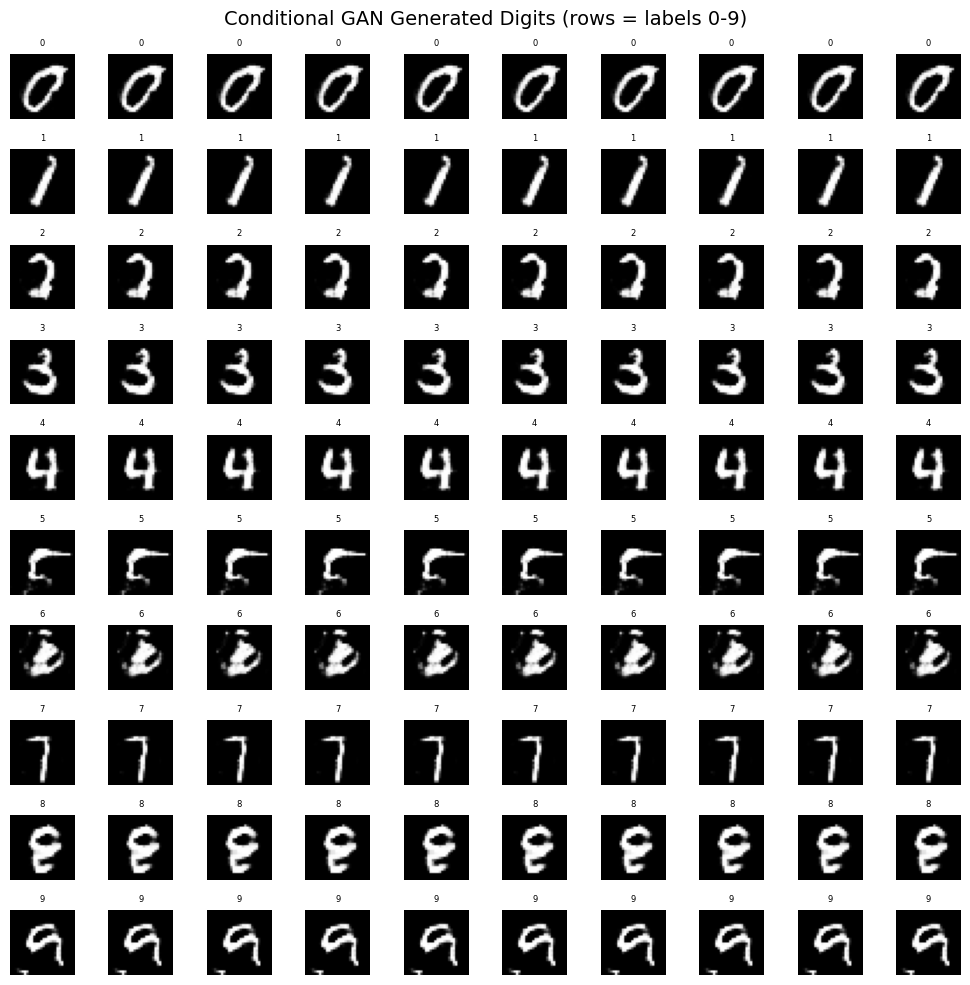

In [6]:
# ============================================
# Display images
# ============================================

def show_generated_grid(model, num_per_class=10):
    images, labels = model.generate_labeled_images(num_per_class=num_per_class)

    num_classes = 10
    fig, axes = plt.subplots(num_classes, num_per_class, figsize=(num_per_class, num_classes))
    fig.suptitle("Conditional GAN Generated Digits (rows = labels 0-9)", fontsize=14)

    idx = 0
    for row in range(num_classes):
        for col in range(num_per_class):
            ax = axes[row, col]
            ax.imshow(images[idx].squeeze(), cmap="gray")
            # Label each image with its requested digit
            ax.set_title(str(labels[idx]), fontsize=6)
            ax.axis("off")
            idx += 1

    plt.tight_layout()
    plt.show()

show_generated_grid(cgan, num_per_class=10)


## Quick Discriminator Accuracy Check (Extra)

In [7]:
# ============================================
# Simple discriminator accuracy check
# ============================================

def evaluate_discriminator_accuracy(model, dataset, num_batches=10):
    total_true = []
    total_pred = []

    for i, (real_images, real_labels) in enumerate(dataset):
        if i >= num_batches:
            break

        batch_size = real_images.shape[0]

        # Real
        real_logits = model.discriminator(
            [real_images, tf.cast(real_labels[:, tf.newaxis], tf.int32)], training=False
        )
        real_probs = tf.math.sigmoid(real_logits)
        real_targets = tf.ones_like(real_probs)

        # Fake
        noise = tf.random.normal(shape=(batch_size, model.latent_dim))
        fake_labels = tf.random.uniform(
            shape=(batch_size, 1), minval=0, maxval=model.num_classes, dtype=tf.int32
        )
        fake_images = model.generator([noise, fake_labels], training=False)
        fake_logits = model.discriminator([fake_images, fake_labels], training=False)
        fake_probs = tf.math.sigmoid(fake_logits)
        fake_targets = tf.zeros_like(fake_probs)

        total_true.append(real_targets)
        total_true.append(fake_targets)
        total_pred.append(real_probs)
        total_pred.append(fake_probs)

    y_true = tf.concat(total_true, axis=0)
    y_pred = tf.concat(total_pred, axis=0)

    acc = keras.metrics.binary_accuracy(y_true, y_pred)
    return float(tf.reduce_mean(acc).numpy())

disc_acc = evaluate_discriminator_accuracy(cgan, dataset)
print(f"Approximate discriminator accuracy (real vs fake): {disc_acc * 100:.2f}%")


Approximate discriminator accuracy (real vs fake): 90.96%


## Explanation 



Throughout this assignment, I learned how **Generative Adversarial Networks (GANs)** work and how to implement them step-by-step using TensorFlow and Keras. The process helped me understand how two neural networks — the **Generator** and the **Discriminator** — compete against each other to improve their performance over time. The Generator learns to create images that look increasingly realistic, while the Discriminator learns to distinguish between real and fake images. This adversarial training process pushes both networks to improve simultaneously.

### Key Takeaways
- I learned how to build and compile both the generator and discriminator models.
- I saw how losses such as `d_loss`, `d_accuracy`, and `g_loss` reflect training progress — where the generator tries to fool the discriminator and the discriminator tries to correctly classify real vs. fake samples.
- Training a GAN requires careful balance to avoid mode collapse or overfitting, and understanding learning rates, epochs, and batch sizes plays a crucial role.
- Visualizing generated samples over epochs showed how the model gradually improves at producing realistic outputs.

### What Makes It a Conditional GAN (cGAN)
A **Conditional GAN (cGAN)** adds an extra input — a **condition** such as a class label — to both the generator and discriminator.  
This means:
- The **Generator** not only takes random noise but also receives a label, so it learns to generate images *conditioned* on that label (for example, generating a specific digit or class).
- The **Discriminator** also receives the label to verify if the generated image matches the condition.

This modification allows the GAN to control what type of image is generated rather than producing random samples, which makes cGANs especially useful for **class-conditioned image generation**, **image-to-image translation**, and **data augmentation** tasks.

### Overall Experience
I learned how powerful and delicate GAN training can be — it involves both creativity in design and precision in hyperparameter tuning. Through running and adjusting epochs, I saw firsthand how the model evolves, the meaning of each metric, and how conditioning improves the control and quality of generated images.
